In [1]:
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.ticker as ticker

In [2]:
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)


In [3]:
data_path = '/media/ssd/Research/aliyun_sync/aliyun_sync/COMPASS/paper/00_data/'
df_label = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE.ALIGN'))

dfp = pd.read_csv('../04_model_performance/02_leave_one_cohort_out/bootstrap_results/LOCO_raw_data.csv', 
                  index_col = 0)

dfp = dfp[dfp['mode'] == 'PFT']
#dfp = dfp[dfp['seed'] == 42]
dfp = dfp.set_index('Index')

df_label = df_label.join(dfp[['NR','R', '0', '1', 'seed']])

#BLCA_primary_tissues = ['Bladder', 'Kidney', 'Ureter']
primary_tissues = ['Bladder', 'Kidney', 'Ureter']
metastatic_tissues = ['Lymph node', 'Lung', 'Liver', 'Brain', 'Soft tissue', 'Other']

data = df_label[df_label.cohort == 'IMVigor210']
data = data[~data.Biopsy_site.isna()]

d = data[data.seed == 42]
n1 = d.Biopsy_site.isin(primary_tissues).sum()
n2 = d.Biopsy_site.isin(metastatic_tissues).sum()

x1 = f'Primary site, n={n1}'
x2 = f'Metastatic site, n={n2}'

tissue_type_map1 = {'Bladder':x1, 'Kidney':x1, 'Ureter':x1, 
                    'Lymph node':x2, 'Lung':x2, 'Liver':x2, 
                    'Other':x2}

# data = df_label[df_label.cohort == 'IMVigor210']

data['tissue_type'] = data.Biopsy_site.map(tissue_type_map1)
data = data[~data.tissue_type.isna()]

print(data.tissue_type.value_counts())

tissue_type
Primary site, n=248      744
Metastatic site, n=44    132
Name: count, dtype: int64


/tmp/ipykernel_1738/1079408945.py:4: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  dfp = pd.read_csv('../04_model_performance/02_leave_one_cohort_out/bootstrap_results/LOCO_raw_data.csv',


In [4]:
d.Biopsy_site.value_counts()

Biopsy_site
Bladder       168
Kidney         56
Ureter         24
Lymph node     22
Lung           10
Other           8
Liver           4
Name: count, dtype: int64

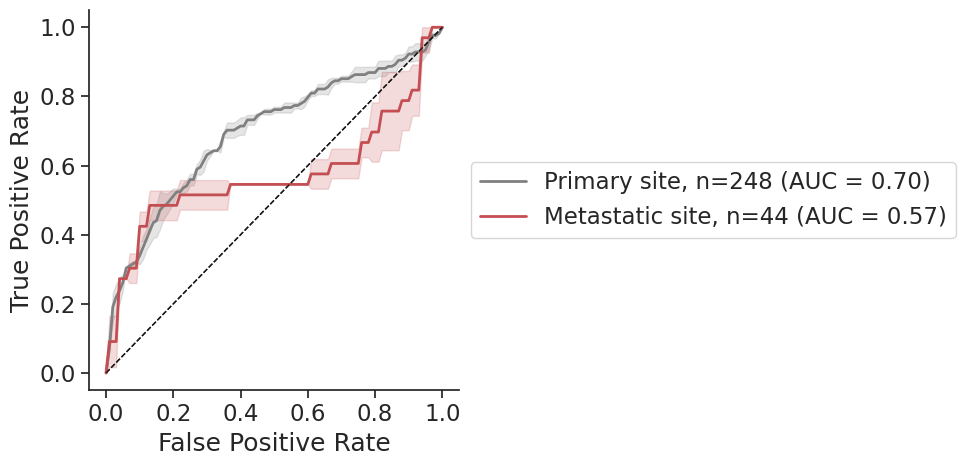

In [5]:

# Create subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), sharey=True)

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
modes = data.tissue_type.unique()
colors = ['grey', 'r']
colors = dict(zip(modes, colors))

for mode in modes:
    mode_data = data[data['tissue_type'] == mode]
    seeds = mode_data['seed'].unique()
    
    color = colors[mode]
    tprs = []
    base_fpr = np.linspace(0, 1, 101)
    
    for seed in seeds:
        seed_data = mode_data[mode_data['seed'] == seed]
        fpr, tpr, _ = roc_curve(seed_data['R'], seed_data['1'])
        tprs.append(np.interp(base_fpr, fpr, tpr))
        tprs[-1][0] = 0.0

    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(base_fpr, mean_tpr)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    
    ax.plot(base_fpr, mean_tpr, label=f'{mode} (AUC = {mean_auc:.2f})', color = color, lw=2)
    ax.fill_between(base_fpr, tprs_lower, tprs_upper, alpha=0.2, color = color)
    ax.plot([0, 1], [0, 1], 'k--', lw=1)
    
ax.legend(
    loc='center left',        
    bbox_to_anchor=(1, 0.5))

ax.tick_params(axis='both', which='major', right = False, 
               top=False, direction = 'out', reset = True)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
fig.tight_layout()
#plt.show()
fig.savefig('./results/BLCA/curve_ROC_Primary_Metastatic.svg', bbox_inches = 'tight',)


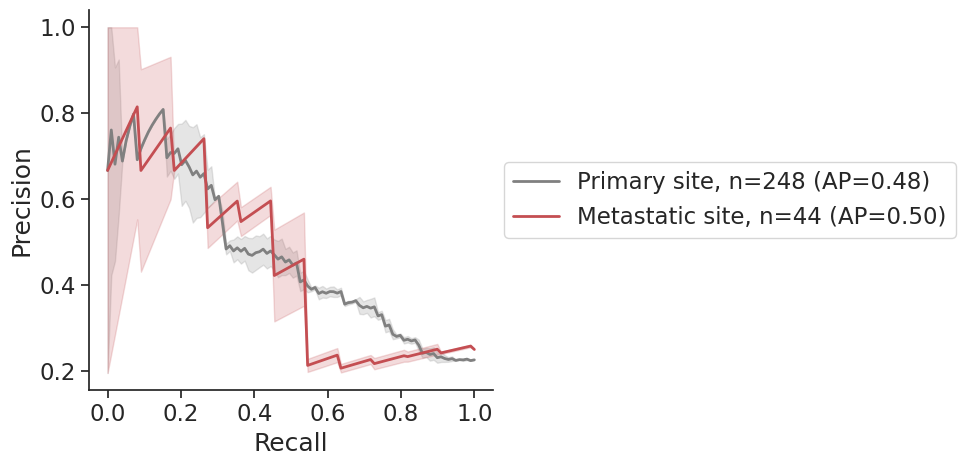

In [6]:
from sklearn.metrics import precision_recall_curve, average_precision_score

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), sharey=True)

for mode in modes:
    mode_data = data[data['tissue_type'] == mode]

    seeds = mode_data['seed'].unique()
    
    precisions = []
    recalls = []
    thresholds = np.linspace(0, 1, 100)
    
    for seed in seeds:
        seed_data = mode_data[mode_data['seed'] == seed]
        precision, recall, _ = precision_recall_curve(seed_data['R'], seed_data['1'])
        precisions.append(np.interp(thresholds, recall[::-1], precision[::-1])[::-1])
        recalls.append(np.interp(thresholds, recall[::-1], recall[::-1])[::-1])
    
    mean_precision = np.mean(precisions, axis=0)
    mean_recall = np.mean(recalls, axis=0)
    mean_ap = average_precision_score(seed_data['R'], seed_data['1'])
    
    std_precision = np.std(precisions, axis=0)
    precisions_upper = np.minimum(mean_precision + std_precision, 1)
    precisions_lower = np.maximum(mean_precision - std_precision, 0)
    
    color = colors[mode]
    ax.plot(mean_recall, mean_precision, label=f'{mode} (AP={mean_ap:.2f})', color=color,lw=2)
    ax.fill_between(mean_recall, precisions_lower, precisions_upper, color=color, alpha=0.2)

ax.legend(
    loc='center left',        
    bbox_to_anchor=(1, 0.5))

ax.tick_params(axis='both', which='major', right = False, 
               top=False, direction = 'out', reset = True)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')


ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
fig.tight_layout()
fig.savefig('./results/BLCA/curve_PRC_Primary_Metastatic.svg', bbox_inches = 'tight',)


In [7]:
primary_tissues = ['Bladder', 'Kidney', 'Ureter']
metastatic_tissues = ['Lymph node', 'Lung', 'Liver', 'Other']

data = df_label[df_label.cohort == 'IMVigor210']
data = data[~data.Biopsy_site.isna()]

d = data[data.seed == 42]
n1 = d.Biopsy_site.isin(['Bladder']).sum()
n2 = d.Biopsy_site.isin(['Lymph node']).sum()
n3 = d.Biopsy_site.isin(['Lung', 'Liver', 'Brain', 'Other']).sum()

x1 = f'Primary(Bladder,n={n1})'
x2 = f'Metastatic(Lymph node,n={n2})'
x3 = f'Metastatic(Lung/Liver/Other,n={n3})'

tissue_type_map2 = {'Bladder':x1,
                    'Lymph node':x2, 
                    'Lung':x3, 
                    'Liver':x3, 
                   'Other':x3}

data['tissue_type'] = data.Biopsy_site.map(tissue_type_map2)
data = data[~data.tissue_type.isna()]
print(data.tissue_type.value_counts())

tissue_type
Primary(Bladder,n=168)               504
Metastatic(Lymph node,n=22)           66
Metastatic(Lung/Liver/Other,n=22)     66
Name: count, dtype: int64


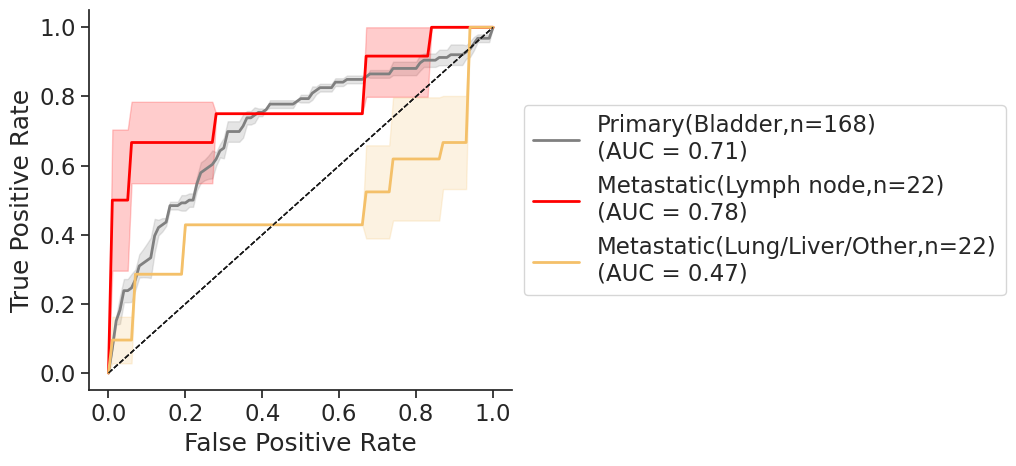

In [8]:
# Create subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10.5, 5), sharey=True)

ax.set_xlabel('False Positive Rate',)
ax.set_ylabel('True Positive Rate',)
modes = data.tissue_type.unique()

colors = ['grey','red',  '#f4c069', '#ff8947'] 
colors = dict(zip(modes, colors))

for mode in modes:
    mode_data = data[data['tissue_type'] == mode]
    seeds = mode_data['seed'].unique()
    
    color = colors[mode]
    tprs = []
    base_fpr = np.linspace(0, 1, 101)
    
    for seed in seeds:
        seed_data = mode_data[mode_data['seed'] == seed]
        fpr, tpr, _ = roc_curve(seed_data['R'], seed_data['1'])
        tprs.append(np.interp(base_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
    
    # rng = np.random.default_rng(seed=42)
    # n_bootstrap= 100
    # for i in range(n_bootstrap):
    #     sample_idx = rng.choice(mode_data.index, size=len(mode_data), replace=True)
    #     sample = mode_data.loc[sample_idx]
    #     fpr, tpr, _ = roc_curve(sample['R'], sample['1'])
    #     tprs.append(np.interp(base_fpr, fpr, tpr))
    #     tprs[-1][0] = 0.0
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(base_fpr, mean_tpr)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    
    ax.plot(base_fpr, mean_tpr, label=f'{mode}\n(AUC = {mean_auc:.2f})', color = color, lw=2)
    ax.fill_between(base_fpr, tprs_lower, tprs_upper, alpha=0.2, color = color)
    ax.plot([0, 1], [0, 1], 'k--', lw=1)
    
ax.legend(
    loc='center left',        
    bbox_to_anchor=(1, 0.5))

ax.tick_params(axis='both', which='major', right = False, 
               top=False, direction = 'out', reset = True)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
fig.tight_layout()
fig.savefig('./results/BLCA/curve_ROC_skin_ln_other.svg', bbox_inches = 'tight',)

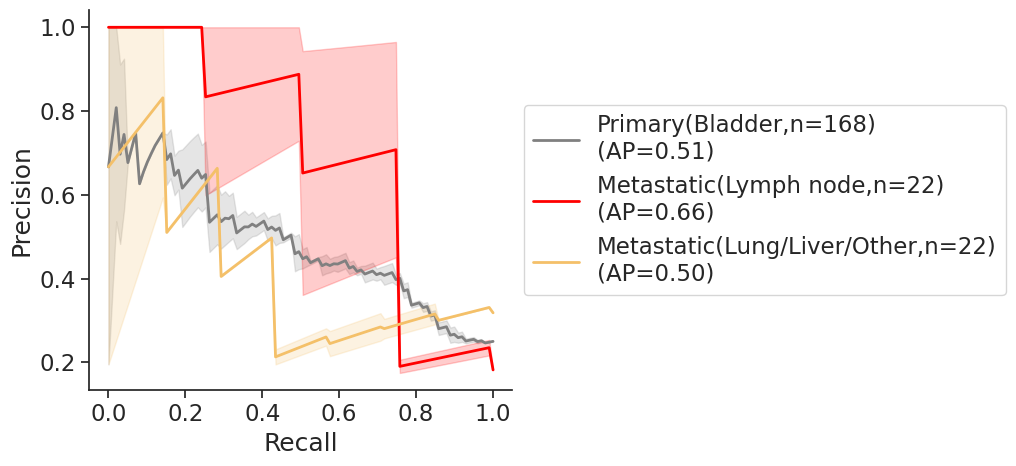

In [9]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Create subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10.5, 5), sharey=True)

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

for mode in modes:
    mode_data = data[data['tissue_type'] == mode]

    seeds = mode_data['seed'].unique()
    
    precisions = []
    recalls = []
    thresholds = np.linspace(0, 1, 100)
    
    for seed in seeds:
        seed_data = mode_data[mode_data['seed'] == seed]
        precision, recall, _ = precision_recall_curve(seed_data['R'], seed_data['1'])
        precisions.append(np.interp(thresholds, recall[::-1], precision[::-1])[::-1])
        recalls.append(np.interp(thresholds, recall[::-1], recall[::-1])[::-1])
    
    mean_precision = np.mean(precisions, axis=0)
    mean_recall = np.mean(recalls, axis=0)
    mean_ap = average_precision_score(seed_data['R'], seed_data['1'])
    
    std_precision = np.std(precisions, axis=0)
    precisions_upper = np.minimum(mean_precision + std_precision, 1)
    precisions_lower = np.maximum(mean_precision - std_precision, 0)
    
    color = colors[mode]
    ax.plot(mean_recall, mean_precision, label=f'{mode}\n(AP={mean_ap:.2f})', color=color,lw=2)
    ax.fill_between(mean_recall, precisions_lower, precisions_upper, color=color, alpha=0.2)

ax.legend(
    loc='center left',        
    bbox_to_anchor=(1, 0.5))

ax.tick_params(axis='both', which='major', right = False, 
               top=False, direction = 'out', reset = True)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
fig.tight_layout()
fig.savefig('./results/BLCA/curve_PRC_skin_ln_other.svg', bbox_inches = 'tight',)

In [10]:
dft = d.groupby(['Biopsy_site','response_label']).size().unstack()

In [11]:
dft

response_label,NR,R
Biopsy_site,,
Bladder,126.0,42.0
Kidney,47.0,9.0
Liver,4.0,NaN
Lung,9.0,1.0
Lymph node,18.0,4.0
Other,2.0,6.0
Ureter,19.0,5.0


In [12]:
metastatic_tissues = ['Lymph node', 'Lung', 'Liver', 'Other']
dft = d.groupby(['Biopsy_site','response_label']).size().unstack()

dft['total'] = dft.sum(axis=1)
dft = dft.loc[primary_tissues]._append(dft.loc[metastatic_tissues])
dft.fillna(0).to_csv('./results/BLCA/Patient_num.tsv', sep = '\t')

In [13]:
dft.fillna(0)

response_label,NR,R,total
Biopsy_site,,,
Bladder,126.0,42.0,168.0
Kidney,47.0,9.0,56.0
Ureter,19.0,5.0,24.0
Lymph node,18.0,4.0,22.0
Lung,9.0,1.0,10.0
Liver,4.0,0.0,4.0
Other,2.0,6.0,8.0


In [14]:
dfct = pd.read_csv('../05_feature_explaination/01_PFT_score_all/01_get_score/02_loco_pft_readouts_celltype.csv',index_col=0)

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().set_output(transform  = "pandas")
dfct = scaler.fit_transform(dfct)

from matplotlib.ticker import PercentFormatter
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize

def radar_plot(series_list, labels, legend_labels, title, cmap, norm, imdict, set_group = False):
    num_vars = len(series_list[0])
    
    # 角度：0 ~ 2pi（然后首尾闭合）
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # 依次画出各条雷达图曲线
    for series, label, legend_label in zip(series_list, labels, legend_labels):
        values = series.tolist()
        values += values[:1]
        color = cmap(norm(imdict[label]))  # 根据标签获取颜色
        ax.plot(angles, values, label=legend_label, linewidth=2, color=color)
        ax.fill(angles, values, alpha=0.25, color=color)

    # 设置角度刻度 & 标签
    ax.set_xticks(angles[:-1])
    # 假设有个外部变量 concept2plot，需要根据需求替换或传参
    ax.set_xticklabels(
        pd.Series(concept2plot).apply(lambda x: x.replace('_', ' ')).tolist(), 
        fontsize=12
    )
    ax.set_yticklabels([])

    #ax.set_title(title, size=15, y=1.2)
    ax.legend(loc='center left', bbox_to_anchor=(1.15, 0.6), fontsize=12, frameon=False)

    # for label in ax.get_xticklabels():
    #     label.set_visible(False)
    
    if set_group:
        # --- 在此处添加“半环”绘制逻辑 ---
        # 1) 获取当前半径坐标范围
        current_ylim = ax.get_ylim()  # (r_min, r_max)
        outer = current_ylim[1]       # 当前外圈位置
        ring_width = 0.05 * (outer - current_ylim[0])  # 半环的厚度，可自定义
    
        # 2) 定义上下半圆的角度范围
        angles_top = np.linspace(0, np.pi, 200)        # 上半圈（0~180度）
        angles_bottom = np.linspace(np.pi, 2*np.pi, 200)  # 下半圈（180~360度）
    
        # 3) 填充上半圈（红色），下半圈（蓝色）
        ax.fill_between(angles_top, outer, outer + ring_width, color='red', alpha=0.3)
        ax.fill_between(angles_bottom, outer, outer + ring_width, color='blue', alpha=0.3)
    
        # 4) 更新极坐标的范围，保证半环不被裁剪
        ax.set_ylim(current_ylim[0], outer + ring_width)

    plt.tight_layout()
    plt.close()
    return fig

In [16]:
concept2plot= [
    
 'Cytotoxic_Tcell',
 'IFNg_pathway',
    'Tcell_general', 
 'CD8_Tcell',
'Stroma',
'Fibroblast',
 'TGFb_pathway',
 'Endothelial',
 'Exhausted_Tcell',
 #    'Innate_lymphoid_cell',
 #    'Bcell_general', 

]

In [17]:

datap = d[['response_label', 'Biopsy_site']].join(dfct[concept2plot])
datap1 = datap #[datap.response_label == 'R']
datap1 = datap1[datap1.Biopsy_site.isin(['Skin','Lymph node', 'Lung', 'Liver', 'Brain'])] #'Skin',
datap1 = datap1.sort_values(['Biopsy_site', 'response_label',])
df = datap1.copy()

In [18]:
df = df.set_index(['Biopsy_site', 'response_label',]).stack().reset_index()
df = df.rename(columns = {'level_2':'concept', 0:'score'})
df.head()

,Biopsy_site,response_label,concept,score
0,Liver,NR,Cytotoxic_Tcell,-1.169018
1,Liver,NR,IFNg_pathway,0.513986
2,Liver,NR,Tcell_general,-0.178127
3,Liver,NR,CD8_Tcell,-0.483214
4,Liver,NR,Stroma,-0.470816


In [19]:
ds = d.Biopsy_site.value_counts()

In [20]:
datap2 = datap1.set_index('Biopsy_site')

In [21]:
original_labels = ['Lymph node', 'Lung', 'Liver',]
series_list = [datap2.loc[i][concept2plot].median() for i in original_labels]
legend_labels = [f"{i} (n={ds[i]})" for i in original_labels]

imdict = {'Skin': -1., 'Lymph node': 3., 'Lung': 2., 'Liver':1, 'Brain':0 }
norm = Normalize(vmin=-1, vmax=3)
cmap = get_cmap('rainbow')

fig = radar_plot(series_list, original_labels, legend_labels, 
                 'TMB radar chart', cmap, norm, imdict)
fig.savefig('./results/BLCA/tme_radar_plot.svg', bbox_inches = 'tight',)

/tmp/ipykernel_1738/1477567085.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('rainbow')


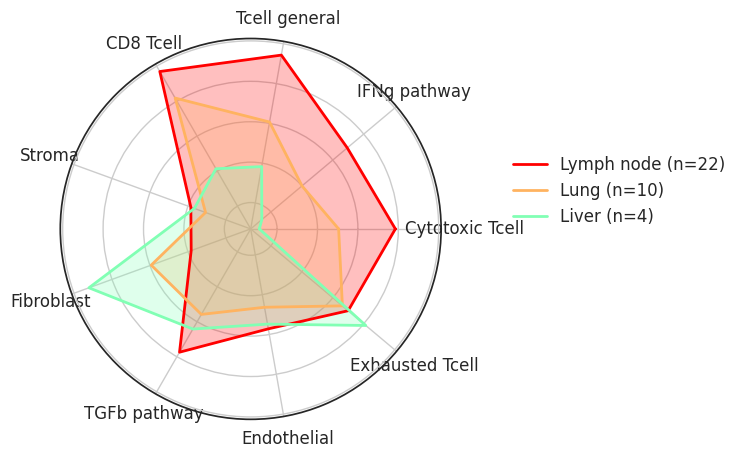

In [22]:
fig

In [23]:
df_clinical = pd.read_pickle(os.path.join(data_path,'./ITRP.PATIENT.TABLE'))

skcm = df_clinical[df_clinical.cohort == 'IMVigor210']
data = skcm.groupby('cohort').apply(lambda x:x.Biopsy_site.value_counts()).unstack()
# data = data.loc[data.sum(axis=1).sort_values(ascending=False).index]
# data = data[data.sum().sort_values(ascending=False).index]


/tmp/ipykernel_1738/499918305.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = skcm.groupby('cohort').apply(lambda x:x.Biopsy_site.value_counts()).unstack()


In [24]:
skcm.groupby('cohort').apply(lambda x:x.Biopsy_site.value_counts()).unstack()

/tmp/ipykernel_1738/1655642526.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  skcm.groupby('cohort').apply(lambda x:x.Biopsy_site.value_counts()).unstack()


Biopsy_site  cohort    
Bladder      IMVigor210    168
Kidney       IMVigor210     56
Ureter       IMVigor210     24
Lymph node   IMVigor210     22
Lung         IMVigor210     10
Other        IMVigor210      8
Liver        IMVigor210      4
dtype: int64

/tmp/ipykernel_1738/2080017547.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = skcm.groupby('cohort').apply(lambda x:x.Biopsy_site.value_counts()).unstack()


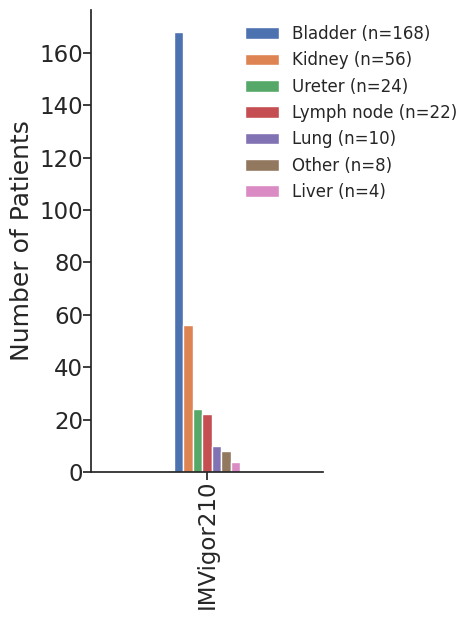

In [25]:
skcm = df_clinical[df_clinical.cancer_type == 'BLCA']
data = skcm.groupby('cohort').apply(lambda x:x.Biopsy_site.value_counts()).unstack()
data = data.loc[data.sum(axis=1).sort_values(ascending=False).index]
data = data[data.sum().sort_values(ascending=False).index]
data = data.loc[['IMVigor210']]


new_columns = [f"{col} (n={int(data[col].sum())})" for col in data.columns]
data.columns = new_columns

fig, ax = plt.subplots(figsize=(3, 6))
data.plot(kind='bar', ax = ax, width = 0.2)
#ax.legend(loc='upper right', ncol=2)

ax.legend(loc='upper left', bbox_to_anchor=(0.6, 1), ncol=1, frameon=False, fontsize=12)
ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
sns.despine(top=True, right=True, left=False, bottom=False)
ax.set_ylabel('Number of Patients')
ax.set_xlabel(None)
fig.savefig('./results/BLCA/blca_bar_plot.svg', bbox_inches = 'tight',)